In [1]:
import os, math, statistics
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as md
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

# T003 DigitalEnergy - Forecast model
## PART 1: Activations (DecTree)
---

### Table of content:
* Input
* Data preparation
* Model preparation
* Evaluation
* Cycles detection & export
* Plot results
* Metrics

### Input

In [2]:
#SET BEFORE RUNNING:
PLANT = "DE_KN_industrial1"
DEVICE = "DE_KN_industrial1_pv_1"   #name without '.csv' (i.e. "DE_KN_industrial1_grid_import")
DATADIR = f"../datas/{PLANT}"
EXP = "./exp/"

#CUSTOM PLOT ZOOM RANGE:
DAY_START = datetime.strptime("2017-09-10 00:00", '%Y-%m-%d %H:%M')
DAY_END = datetime.strptime("2017-10-10 23:59", '%Y-%m-%d %H:%M')

#TRAIN/TEST SPLIT FROM DATE:
TEST_PCT = 0.30
MODELNAME = "DecTreeRegressor"

In [3]:
#CONTROL PARAMETERS:
RESAMPLING_FREQ = 60   #resampling frequency (in minutes)
LEAD = 1   #forecast lead after resampling (shift forward in time for targets Y)
ZSCORE_THR = 15   #threshold for zscore (outliers zeroing)
SIGNIFICANCE = 0.05   #min % cutoff threshold for values
LOOKBACK = 5   #number of lags columns to add

---

## Data preparation
Preparation of a DataFrame with the data recorded for all devices of the selected plant.

All data are converted to incremental values.

In [4]:
#Task 2:
LFS = 12
dataframes = []
files = os.listdir(DATADIR)
files.sort()
for el in files:
    dev = el[:-4] #drop ".csv" from filename
    df = pd.read_csv(f"{DATADIR}/{el}")
    df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'], format='%Y-%m-%d %H:%M')
    #get incremental values:
    df[dev] = df[dev].diff()
    #df.fillna(0, inplace=True)
    #df = df[(np.abs(Counts.zscore(df['value']))<3)]
    df.rename(columns={"utc_timestamp": "timestamp"}, inplace=True)
    dataframes.append(df)
    
for el in dataframes[1:]:
    dataframes[0] = dataframes[0].merge(el, how='outer', on='timestamp')
    
data = dataframes[0]
data.sort_values(by='timestamp', inplace=True)
data.reset_index(drop=True, inplace=True)

#set global:
DEVICES = list(data.columns)

### Extract device data & resample

In [5]:
#create Device dataframe:
Device = pd.DataFrame({'timestamp': data['timestamp'], 'value': data[DEVICE]})
Device.dropna(inplace=True)
Device.set_index('timestamp', inplace=True)

#zero all outliers:
Device['value'] = np.where((np.abs(stats.zscore(Device['value'])) < ZSCORE_THR), Device['value'], 0)

#resample:
Device = Device.resample(f'{RESAMPLING_FREQ}T').sum()

#min value threshold:
threshold = Device['value'].max()*SIGNIFICANCE
print(f"Max value recorded: {Device['value'].max()}")
print(f"Min significance threshold: {threshold}")
Device[Device['value'] < threshold] = 0

Device.head(10)

Max value recorded: 4.75
Min significance threshold: 0.23750000000000002


,value
timestamp,
2015-10-23 14:00:00,0.0
2015-10-23 15:00:00,0.0
2015-10-23 16:00:00,0.0
2015-10-23 17:00:00,0.0
2015-10-23 18:00:00,0.0
2015-10-23 19:00:00,0.0
2015-10-23 20:00:00,0.0
2015-10-23 21:00:00,0.0
2015-10-23 22:00:00,0.0


### Normalize

In [6]:
#Normalize values:
val_scaler = MinMaxScaler().fit(Device['value'].to_numpy().reshape(-1,1))
vals = val_scaler.transform(Device['value'].to_numpy().reshape(-1,1))

#Create Normalized DataFrame:
DeviceNd = Device.copy()
DeviceNd['value'] = vals

DeviceNd.head(10)

,value
timestamp,
2015-10-23 14:00:00,0.0
2015-10-23 15:00:00,0.0
2015-10-23 16:00:00,0.0
2015-10-23 17:00:00,0.0
2015-10-23 18:00:00,0.0
2015-10-23 19:00:00,0.0
2015-10-23 20:00:00,0.0
2015-10-23 21:00:00,0.0
2015-10-23 22:00:00,0.0


### Add lag columns

In [7]:
#function:
def lag_columns(df, col, lookback):
    lag_names = []
    for i in range(lookback):
        lag_names.append(f"lag_{i+1}")
        df[f'lag_{i+1}'] = df[col].shift(i+1)
    df.fillna(0, inplace=True)
    return df, lag_names

In [8]:
#add lags:
DeviceNd['target'] = DeviceNd['value'].shift(-LEAD)
DeviceNd, lag_names = lag_columns(DeviceNd, 'value', LOOKBACK)

DeviceNd.head(10)

,value,target,lag_1,lag_2,lag_3,lag_4,lag_5
timestamp,,,,,,,
2015-10-23 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-10-23 15:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-10-23 16:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-10-23 17:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-10-23 18:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-10-23 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-10-23 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-10-23 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-10-23 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature engineering

In [9]:
#FEATURE ENGINEERING:
months = []
days = []
weekdays = []
hours = []
time_from_act = 0
times = []
acts = 0

#identify start Cycle moments:
DeviceNd['change'] = (DeviceNd['value']==0) & (DeviceNd['value'].diff(periods=-1).fillna(0)<0)

#Cycles characterization:
DeviceNd.reset_index(inplace=True)
for ind in DeviceNd.index:
    ts = pd.Timestamp(DeviceNd['timestamp'].iloc[ind])
    months.append(ts.month)
    weekdays.append(ts.isoweekday()) #'1' is Monday
    days.append(ts.day)
    hours.append(ts.hour)
    if DeviceNd['change'].iloc[ind] == True:
        #update Cycle start details:
        time_from_act = 0
        acts += 1
    else:
        time_from_act += 1
    times.append(time_from_act)

DeviceNd['month'] = months
DeviceNd['day'] = days
DeviceNd['weekday'] = weekdays
DeviceNd['hour'] = hours

#enable feature "time_from_activation":
# DeviceNd['time_from_activation'] = times
# DeviceNd['time_from_activation'] = DeviceNd['time_from_activation'].shift(1)
# DeviceNd['time_from_activation'].fillna(0, inplace=True)

DeviceNd.set_index('timestamp', inplace=True)
DeviceNd.drop(columns=['change'], inplace=True)
DeviceNd.head(10)

,value,target,lag_1,lag_2,lag_3,lag_4,lag_5,month,day,weekday,hour
timestamp,,,,,,,,,,,
2015-10-23 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,23,5,14
2015-10-23 15:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,23,5,15
2015-10-23 16:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,23,5,16
2015-10-23 17:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,23,5,17
2015-10-23 18:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,23,5,18
2015-10-23 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,23,5,19
2015-10-23 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,23,5,20
2015-10-23 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,23,5,21
2015-10-23 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,23,5,22


CHECK if the device has activations or if it is always on:

In [10]:
#extract dates:
Temp = pd.DataFrame({'days': Device.index.date})
dates = len(Temp['days'].unique().tolist())

#get count of activations:
print(f"Number of dates: {dates}")
print(f"Number of activations: {acts}")

#mode:
mode = round(float(DeviceNd['value'].mode()),2)
print(f"Distribution mode: {mode}")

#For a device to have activation cycles it must activate at least once in a given percentage of days.
#If this does not happen, the device has no cycles:
if acts <= dates*(0.15):
    HAS_CYCLES = False
    print(f">>> The device has NO activation cycles.")
    if 'time_from_activation' in DeviceNd.columns:
        DeviceNd.drop(columns=['time_from_activation'], inplace=True)   #useless if no cycles
else:
    HAS_CYCLES = True
    print(f">>> The device HAS activation cycles.")

Number of dates: 721
Number of activations: 724
Distribution mode: 0.0
>>> The device HAS activation cycles.


Get list of feature names (for dynamic analysis):

In [11]:
#extract features:
buffer = list(DeviceNd.columns)
features = ['value']   #all
t_feats = []  #support
for feat in buffer:
    if feat != 'value' and feat != 'target':
        features.append(feat)
        if feat[:3] != 'lag':
            t_feats.append(feat)
print(features)
print(t_feats)

['value', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'month', 'day', 'weekday', 'hour']
['month', 'day', 'weekday', 'hour']


### Normalize time features

In [12]:
#Normalize values:
t_scalers = {}
for t_feat in t_feats:
    t_scalers[t_feat] = MinMaxScaler().fit(DeviceNd[t_feat].to_numpy().reshape(-1, 1))
    DeviceNd[t_feat] = t_scalers[t_feat].transform(DeviceNd[t_feat].to_numpy().reshape(-1, 1))
    
DeviceNd.head(10)

,value,target,lag_1,lag_2,lag_3,lag_4,lag_5,month,day,weekday,hour
timestamp,,,,,,,,,,,
2015-10-23 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.818182,0.733333,0.666667,0.608696
2015-10-23 15:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.818182,0.733333,0.666667,0.652174
2015-10-23 16:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.818182,0.733333,0.666667,0.695652
2015-10-23 17:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.818182,0.733333,0.666667,0.739130
2015-10-23 18:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.818182,0.733333,0.666667,0.782609
2015-10-23 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.818182,0.733333,0.666667,0.826087
2015-10-23 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.818182,0.733333,0.666667,0.869565
2015-10-23 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.818182,0.733333,0.666667,0.913043
2015-10-23 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.818182,0.733333,0.666667,0.956522


### Create targets

In [13]:
X = DeviceNd[features]
Y = DeviceNd['target']
n_features = X.shape[1]

---

## Model preparation

### Calculate test_start date (for dataset split)

In [14]:
#View of all dates in timeseries:
print(f"Dates in dataset -> START: {DeviceNd.index[0]}, END: {DeviceNd.index[-1]}")
dates = list(DeviceNd.index)
tot = len(dates)
print(f"Total timeseries length: {tot}")

#Get test cutoff index:
train_pct = 1 - TEST_PCT
test_cutoff = int(round(tot * train_pct, 0))
print(f"Test start at index: {test_cutoff}")

#Get date corresponding to test cutoff index:
test_start = dates[test_cutoff]
print(f"Test start date: {test_start}")

Dates in dataset -> START: 2015-10-23 14:00:00, END: 2017-10-12 21:00:00
Total timeseries length: 17288
Test start at index: 12102
Test start date: 2017-03-10 20:00:00


### Train-test split

In [15]:
#TRAIN/VAL/TEST SPLIT:
X_train = X[:test_cutoff]
X_test = X[test_cutoff:]
Y_train = Y[:test_cutoff]
Y_test = Y[test_cutoff:]

X.shape, Y.shape, X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((17288, 10), (17288,), (12102, 10), (12102,), (5186, 10), (5186,))

### Build & fit model

In [16]:
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, Y_train)
print("Training complete.")

Training complete.


---

## Evaluation

### Get predictions & metrics

In [17]:
#build a dynamic dataframe to consider past predictions on the same row

#This function is used during the prediction phase
#Basically it manages the LOOKBACK part of the code
def Dyn_df(LOOKBACK,X_pred,preds):
    buf=X_pred.iloc[ind]
    buf["value"] = preds.iloc[-1]
    X_pred.iloc[ind] =buf
    for idx,feat in enumerate(lag_names):
        X_pred[feat][ind]=preds.iloc[-idx-2]
    return X_pred,preds

X_pred = pd.concat([X_train,X_test])
preds=X_pred.value[X_train.shape[0]-LOOKBACK-2:X_train.shape[0]] 

for ind in range(X_train.shape[0]-1,len(X_pred)):
    X_pred, preds=Dyn_df(LOOKBACK,X_pred,preds)
    inputs=pd.DataFrame(X_pred.iloc[ind]).T
    preds_temp=(pd.Series(model.predict(inputs)))
    preds_temp[preds_temp<=0]=0
    preds=preds.append(preds_temp)


X_pred=X_pred[X_train.shape[0]:]
preds=preds[LOOKBACK+3:]
print(X_pred.shape)
print(preds.shape)

X_pred.head(10)

(5186, 10)
(5186,)


,value,lag_1,lag_2,lag_3,lag_4,lag_5,month,day,weekday,hour
timestamp,,,,,,,,,,
2017-03-10 20:00:00,0.0,0.0,0.0,0.0,0.197895,0.475789,0.181818,0.300000,0.666667,0.869565
2017-03-10 21:00:00,0.0,0.0,0.0,0.0,0.000000,0.197895,0.181818,0.300000,0.666667,0.913043
2017-03-10 22:00:00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.181818,0.300000,0.666667,0.956522
2017-03-10 23:00:00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.181818,0.300000,0.666667,1.000000
2017-03-11 00:00:00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.181818,0.333333,0.833333,0.000000
2017-03-11 01:00:00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.181818,0.333333,0.833333,0.043478
2017-03-11 02:00:00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.181818,0.333333,0.833333,0.086957
2017-03-11 03:00:00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.181818,0.333333,0.833333,0.130435
2017-03-11 04:00:00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.181818,0.333333,0.833333,0.173913


In [18]:
#PREDICT:
# preds = model.predict(X_test)
# print(preds[0:10])

#SCORE:
mse = mean_squared_error(Y_test, preds)
print(f"MSE: {mse:.5f}")
print(f"RMSE: {math.sqrt(mse):.5f}")

MSE: 0.05139
RMSE: 0.22668


### Consolidate data

Add column with predictions to Device dataframe

In [19]:
#Join to DeviceNd dataframe:
#column must be populated only for the test timeframe:
nan_col = np.empty(test_cutoff)
nan_col[:] = np.NaN
print(len(nan_col))

#add normalized preds:
DeviceNd['preds'] = np.concatenate((nan_col, preds))
# DeviceNd['preds'] = DeviceNd['preds'].shift(LEAD)
# DeviceNd.fillna(0, inplace=True)
DeviceNd[DeviceNd < 0] = 0
print(len(DeviceNd['preds']))

12102
17288


De-normalize

In [20]:
#de-normalize predictions:
Device['preds'] = val_scaler.inverse_transform(DeviceNd['preds'].to_numpy().reshape(-1, 1))

Device.tail(10)

,value,preds
timestamp,,
2017-10-12 12:00:00,1.365,1.718
2017-10-12 13:00:00,1.322,1.152
2017-10-12 14:00:00,1.097,0.465
2017-10-12 15:00:00,0.296,0.000
2017-10-12 16:00:00,0.000,0.000
2017-10-12 17:00:00,0.000,0.000
2017-10-12 18:00:00,0.000,0.000
2017-10-12 19:00:00,0.000,0.000
2017-10-12 20:00:00,0.000,0.000


---

## Cycles detection & export

Detect cycles

In [21]:
if HAS_CYCLES == True:
    #Hybrid column: original values where preds == Nan, else preds:
    values = np.where(Device['preds'].notna(), Device['preds'], Device['value'])

    #create Cycles DataFrame:
    Cycles = pd.DataFrame({'timestamp': Device.index, 'value': values})

    #identify start Cycle moments:
    Cycles['change'] = (Cycles['value']==0) & (Cycles['value'].diff(periods=-1).fillna(0)<0)

    #extract start timestamps for each cycle & populate df:
    act_months = []
    act_days = []
    act_hours = []
    month = np.NaN
    day = np.NaN
    hour = np.NaN
    i = 0
    time_from_act = 0
    times = []


    for ind in Cycles.index:
        #when a new Cycle starts:
        if Cycles['change'].iloc[ind] == True:
            #update Cycle start details:
            time_from_act = 0
            start = pd.Timestamp(Cycles['timestamp'].iloc[ind])
            month = start.month
            day = start.day
            hour = start.hour
        else:
            time_from_act += 1
        #for each row: store last Cycle start details:
        times.append(time_from_act)
        act_months.append(month)
        act_days.append(day)
        act_hours.append(hour)
        i += 1

    Cycles['time_from_activation'] = times
    # Cycles['month_activation'] = act_months
    # Cycles['day_activation'] = act_days
    # Cycles['hour_activation'] = act_hours

    Cycles.tail(10)

Export

In [22]:
#EXPORT:
if HAS_CYCLES == True:
    Cycles.to_csv(f"{EXP}{DEVICE}_preds.csv", index=False)

---

## Plot results

### Choose what to plot (normalized or not normalized)

In [23]:
#UNCOMMENT WHAT NEEDED:

#ToPlot = DeviceNd.copy()  #normalized
ToPlot = Device.copy()  #not normalized

### Plot entire series

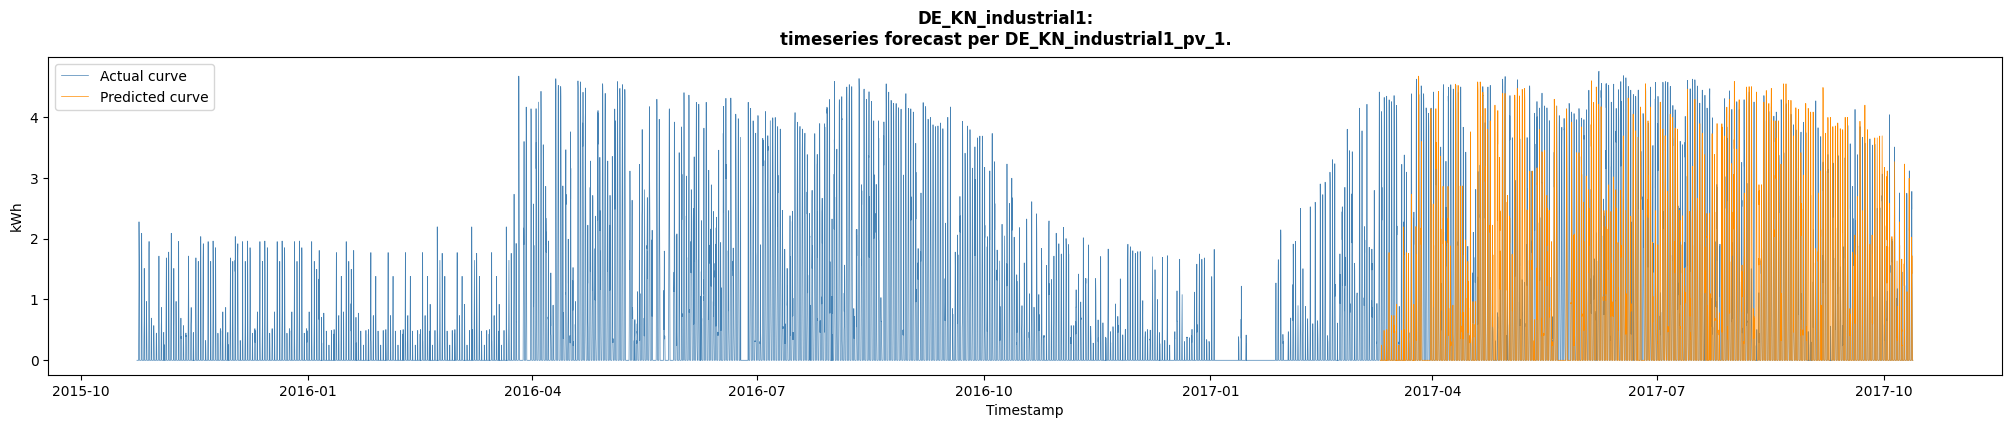

In [24]:
#ENTIRE SERIES:
fig, ax = plt.subplots(1, 1, figsize=(1920/96, 400/96), constrained_layout=True)
fig.suptitle(f"{PLANT}:\ntimeseries forecast per {DEVICE}.", fontsize=LFS, fontweight='bold')

ax.plot(ToPlot.index, ToPlot['value'], color='steelblue', linewidth=0.5)
ax.plot(ToPlot.index, ToPlot['preds'], color='darkorange', linewidth=0.5)
ax.legend(["Actual curve", "Predicted curve"])
ax.set_ylabel("kWh")
ax.set_xlabel("Timestamp")

plt.show()

### Zoom to test timeframe

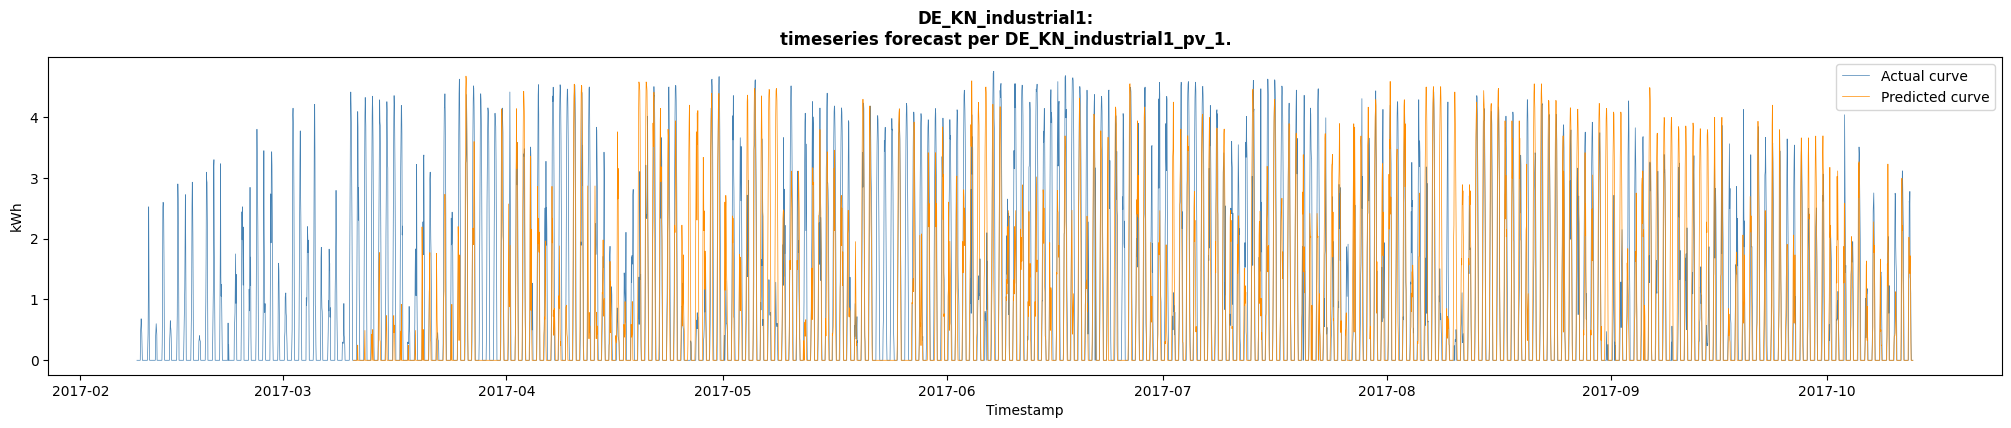

In [25]:
#TEST SET:
fig, ax = plt.subplots(1, 1, figsize=(1920/96, 400/96), constrained_layout=True)
fig.suptitle(f"{PLANT}:\ntimeseries forecast per {DEVICE}.", fontsize=LFS, fontweight='bold')

#Add one month of earlier observations:
PLOT_LEAD = 30 * int(round(1440/RESAMPLING_FREQ, 0))
ax.plot(ToPlot.index[test_cutoff-PLOT_LEAD:], ToPlot['value'][test_cutoff-PLOT_LEAD:], color='steelblue', linewidth=0.5)
ax.plot(ToPlot.index[test_cutoff-PLOT_LEAD:], ToPlot['preds'][test_cutoff-PLOT_LEAD:], color='darkorange', linewidth=0.5)
ax.legend(["Actual curve", "Predicted curve"])
ax.set_ylabel("kWh")
ax.set_xlabel("Timestamp")

plt.show()

### Zoom to custom timeframe

Dates check

In [26]:
print(f"Test start: {test_start}")
print(f"Last day in timeseries: {Device.index[-1]}")

#dates correction:
if DAY_START < test_start or DAY_END > Device.index[-1]:
    DAY_START = test_start + timedelta(days=60)
    DAY_END = DAY_START + timedelta(days=60)
    print(f"Zoom dates corrected to {DAY_START} and {DAY_END}")

Test start: 2017-03-10 20:00:00
Last day in timeseries: 2017-10-12 21:00:00


Time slicing

In [27]:
#TIME SLICING:
filt = ToPlot.copy()
filt.reset_index(inplace=True)
filt = filt.loc[(filt['timestamp'] >= DAY_START) & (filt['timestamp'] <= DAY_END)]
filt['timestamp'] = pd.to_datetime(filt['timestamp'], format='%Y-%m-%d %H:%M')
#filt.head(10)

Plot

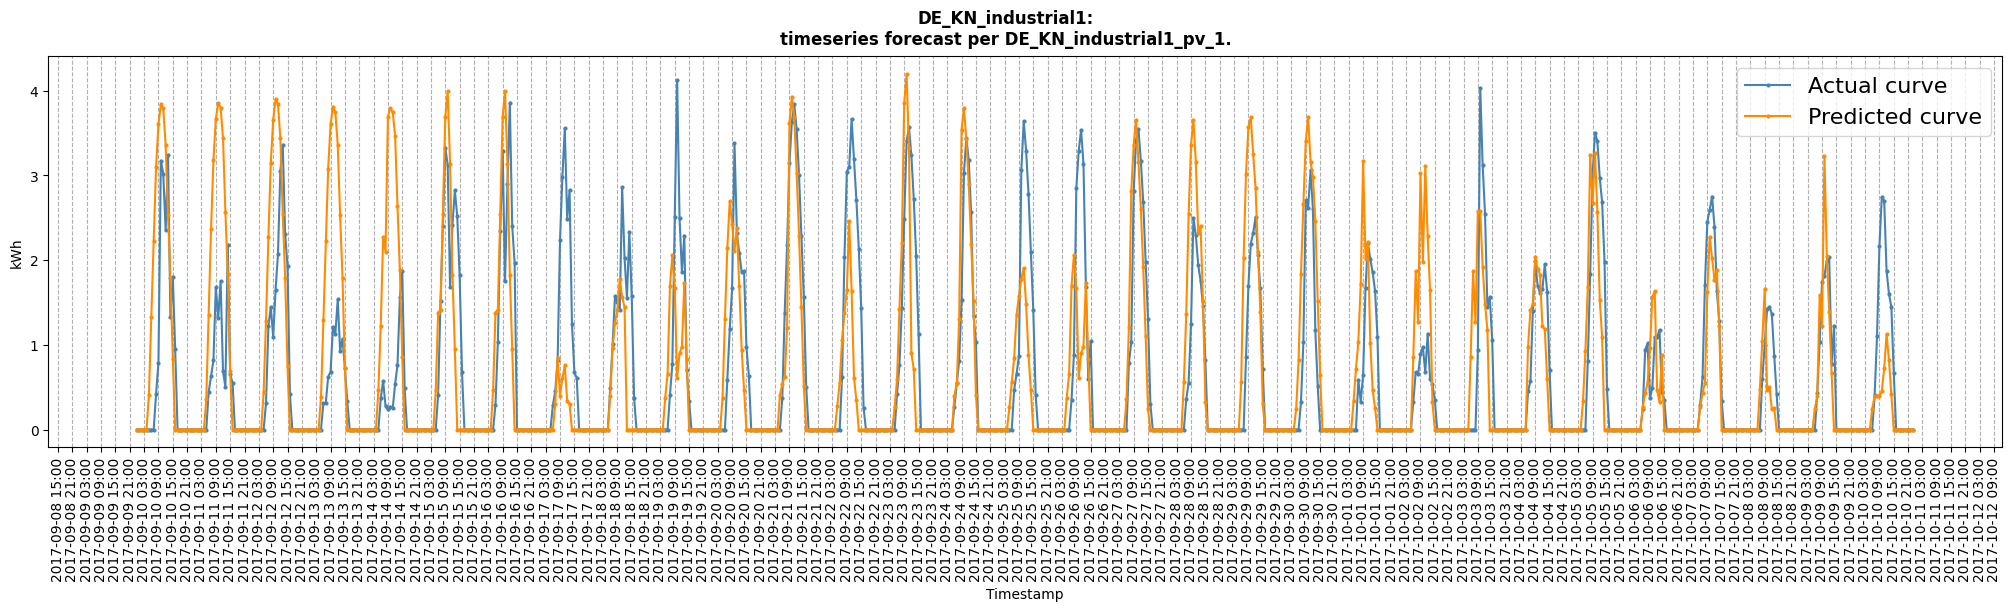

In [28]:
fig, sub1 = plt.subplots(1, 1, figsize=(1920/96, 576/96), constrained_layout=True)
fig.suptitle(f"{PLANT}:\ntimeseries forecast per {DEVICE}.", fontsize=LFS, fontweight='bold')

delta = (DAY_END-DAY_START).days

sub1.plot(filt['timestamp'], filt['value'], 'steelblue', linewidth=1.5, marker='o', markersize=2, label="Actual curve")
sub1.plot(filt['timestamp'], filt['preds'], 'darkorange', linewidth=1.5, marker='o', markersize=2, label="Predicted curve")
sub1.legend(prop={'size': 16})
sub1.set_xticks(filt['timestamp'])
sub1.set_xticklabels(filt['timestamp'],rotation=90)
sub1.set_xlabel(f"Timestamp")
sub1.grid(axis="x",linestyle="--")
sub1.set_ylabel("kWh")
#set time format and the interval of ticks (every 30 minutes):
xformatter = md.DateFormatter('%Y-%m-%d %H:%M')
if delta > 1:
    xlocator = md.HourLocator(interval = 6)
    sub1.xaxis.set_major_locator(xlocator)
sub1.xaxis.set_major_formatter(xformatter)
plt.show()

---

## Metrics

### Features importance

In [29]:
#Build features importance dict:
imp_scores = model.feature_importances_
total = sum(imp_scores)
f_importance = {}
i=0

for feat in features:
    f_importance[feat] = imp_scores[i]/total
    i = i+1
print(f_importance)

{'value': 0.8555444686018443, 'lag_1': 0.014512694987190931, 'lag_2': 0.010618083573691381, 'lag_3': 0.0062195347398391835, 'lag_4': 0.004975862469633598, 'lag_5': 0.00202997447286456, 'month': 0.010717216472568928, 'day': 0.011258650188371551, 'weekday': 0.0063271874595670725, 'hour': 0.07779632703442854}


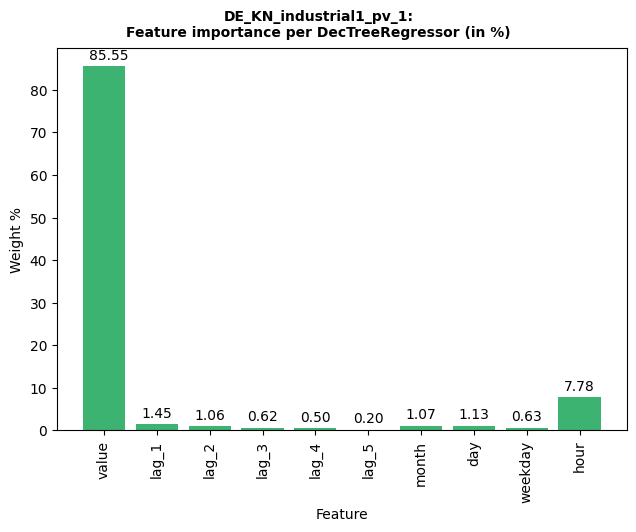

In [30]:
fig, sub1 = plt.subplots(1, 1, figsize=(600/96, 500/96), constrained_layout=True)
fig.suptitle(f"{DEVICE}:\nFeature importance per {MODELNAME} (in %)", fontsize=10, fontweight='bold')

xpos = np.arange(len(f_importance.keys()))
ylist = [v*100 for v in f_importance.values()]
sub1.bar(xpos, ylist, color='mediumseagreen')

for x, y in zip(xpos, ylist):
    plt.annotate(f"{y:.2f}", #text
                (x, y), #coordinates to position the label
                textcoords="offset points", #how to position the text
                xytext=(-11, 5)) #distance from text to points (x,y)

sub1.set_xlabel("Feature")
sub1.set_ylabel("Weight %")
sub1.set_xticks(xpos)
sub1.set_xticklabels(f_importance.keys(), rotation=90)
plt.show()

### Consumption ratio
in this chapter it is performed the total consumption analysis on the test set, in order to compare the predicted consumption with the actual consumption

In [31]:
Actual_consumption=X_test["value"].sum()
predicted_consumption=preds.sum()
consumption_ratio=predicted_consumption/Actual_consumption
print(f"The consumption ratio is {consumption_ratio}")

The consumption ratio is 0.8282350500229271


### Number of activations

In [32]:
if HAS_CYCLES == True:
    ##Compute metrics for actual values
    Activations_act = (X_test['value']==0) & (X_test['value'].diff(periods=-1).fillna(0)<0)
    Activations_act_idx=np.where(Activations_act==1)
    Deactivations_act=(X_test['value']==0) & (X_test['value'].diff(periods=1).fillna(0)<0)
    Deactivations_act_idx=np.where(Deactivations_act==1)
    Activations_act_df=pd.DataFrame()

    Activations_act_df["Activations"]=Activations_act
    Activations_act_df["Deactivations"]=Deactivations_act
    Activations_act_df["month"]=DeviceNd.month[test_cutoff:]
    Activations_act_df["day"]=DeviceNd.day[test_cutoff:]

    Activations_act_per_day=Activations_act_df.groupby(["month","day"]).sum()
    Total_activations_act=Activations_act_per_day.sum()
    Activations_act_per_day_mean=Activations_act_per_day.mean()

    ##Compute metrics for preds values
    Activations_preds = (preds==0) & (preds.diff(periods=-1).fillna(0)<0)
    Activations_preds_idx=np.where(Activations_preds==1)
    Deactivations_preds=(preds==0) & (preds.diff(periods=1).fillna(0)<0)
    Deactivations_preds_idx=np.where(Deactivations_preds==1)
    Activations_preds_df=pd.DataFrame()

    Activations_preds_df["Activations"]=Activations_preds
    Activations_preds_df["Deactivations"]=Deactivations_preds
    Activations_preds_df["month"]=np.array(DeviceNd.month[test_cutoff:])
    Activations_preds_df["day"]=np.array(DeviceNd.day[test_cutoff:])

    Activations_preds_per_day=Activations_preds_df.groupby(["month","day"]).sum()
    Total_activations_preds=Activations_preds_per_day.sum()
    Activations_preds_per_day_mean=Activations_preds_per_day.mean()

    print(f"The total activations are: Actual: {Total_activations_act[0]} ,Predicted: {Total_activations_preds[0]}")

The total activations are: Actual: 225 ,Predicted: 216
